# Анализ поведения пользователей в мобильном приложении

**Цель исседования:** проанализировать поведение пользователей в мобильном приложении для управления вовлеченностью пользователей и адаптации приложения по целевой и смежной аудитории.    

**Задача:** проанализировать связь целевого события (просмотра контактов) и других действий пользователей. Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.    

**Описание данных:**      
     
Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в *mobile_sources.csv*: 

- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в mobile_dataset.csv: **

- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1`—`search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

## Изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import numpy as np
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import math as mth
import warnings
warnings.filterwarnings('ignore')

In [2]:
# выгрузим даные
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
display(mobile_dataset.head(3))

mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')
display(mobile_sources.head(3))

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex


In [3]:
# переименуем колонки в датасетах
mobile_dataset.columns = mobile_dataset.columns.str.replace('.','_', regex=True)
display(mobile_dataset.columns)

mobile_sources.columns = ['user_id', 'source']
display(mobile_sources.columns)

Index(['event_time', 'event_name', 'user_id'], dtype='object')

Index(['user_id', 'source'], dtype='object')

In [4]:
# посмотрим общую информацию
mobile_dataset.info()
print('')
mobile_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


**Изучена общая информация, переименованы столбцы в датасетах.**

## Предобработка данных

In [5]:
# изменим тип данных в столбце с датой таблицы mobile_dataset
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'], format='%Y-%m-%dT%H:%M:%S')
print('тип данных "event_time"', mobile_dataset.event_time.dtype)

# создадим столбец с датой
mobile_dataset['date'] = mobile_dataset['event_time'].astype('datetime64[D]')
mobile_dataset.head(3)

тип данных "event_time" datetime64[ns]


,event_time,event_name,user_id,date
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07


In [6]:
# посмотрим дубликаты
display(mobile_dataset.duplicated().sum())
display(mobile_sources.duplicated().sum())

0

0

In [7]:
# посмотрим пропуски
display(mobile_dataset.isna().sum())
display(mobile_sources.isna().sum())

event_time    0
event_name    0
user_id       0
date          0
dtype: int64

user_id    0
source     0
dtype: int64

In [8]:
# объединим таблицы
df = mobile_dataset.merge(mobile_sources, on='user_id', how='left')
df.head(3)

,event_time,event_name,user_id,date,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex


In [9]:
# посмотрим уникальные события 
df.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Видим, что show_contacts на contacts_show это дубликаты

In [10]:
# занименим show_contacts на contacts_show
df.loc[df['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'
df.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

In [11]:
# посмотрим уникальные источники
df.source.unique()

array(['other', 'yandex', 'google'], dtype=object)

In [12]:
# еще раз проверим дубликаты
display(df.duplicated().sum())

0

**Пропусков не обнаружено, обработаны дубликаты в столбце с событиями, добавлен столбец с датой.**

## Исследовательский анализ данных

### Выделение сессий пользователя

In [13]:
# найдем среднее время, когда пользователь совершал действие и отсортируем по увеличению времени
user_event = df.sort_values(by = ['user_id','event_time'])

# создадим столбец с разницей во времени между действиями пользователя
user_event['delta'] = user_event.groupby(['user_id'])['event_time'].apply(lambda x: x.diff())

# переведем столбец с разницей во времени в минуты
user_event['delta_min'] = user_event['delta'].astype('timedelta64[m]', errors = 'ignore') \
    .astype('int64', errors = 'ignore').fillna(0)

# создадим переменную с количеством минут в 1 дне
minute = 1440

# посчитаем в разрезе одного дня среднее время между собитиями пользователей в минутах
print('Среднее время одной сессии в минутах' , round(user_event.query('delta_min < @minute')['delta_min'].mean()))
print('Среднее время одной сессии в часах' , round((user_event.query('delta_min < @minute')['delta_min'].mean()/60), 1))
display(user_event.head(5))

Среднее время одной сессии в минутах 26
Среднее время одной сессии в часах 0.4


,event_time,event_name,user_id,date,source,delta,delta_min
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,NaT,0.0
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0 days 00:00:45.063550,0.0
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0 days 00:00:34.669580,0.0
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0 days 00:02:15.012972,2.0
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0 days 00:02:10.182041,2.0


Исходя из рассчета, что среднее время одной сессии составляет 26 минут, полагаю логичным, взять время в 30 минут для выделения сессий пользователя.

In [14]:
# добавим сессии пользователя
# для начала отсортируем датасет
df = df.sort_values(['user_id', 'event_time'])

# возьмем за 1 сессию промежуток в 30 минут, если между событиями время больше 30 минут, считаем это разными сессиями                                       
s = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
df['session_id'] = df.groupby(['user_id', s], sort=False).ngroup() + 1
df.head(15)

,event_time,event_name,user_id,date,source,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,other,2


**На основе проведенного исследования, что в среднем сессия пользователя длится до 30 минут, выделены сессий пользователей.**

### Анализ поведения пользователей

In [15]:
# посчитаем сколько всего событий в логе
print('всего событий:', df.event_name.count())

всего событий: 74197


In [16]:
# посчитаем сколько всего пользователей в логе
print('всего пользователей:', df.user_id.nunique())

всего пользователей: 4293


In [17]:
# посчитаем сколько в среднем событий приходится на пользователя
print('в среднем:', round(df.event_name.count() / df.user_id.nunique()), 'события приходится на пользователя')

в среднем: 17 события приходится на пользователя


по медиане: 9 событий приходится на пользователя


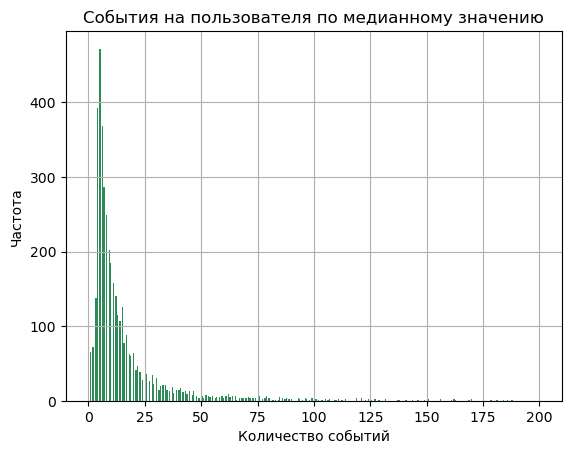

In [105]:
# посчитаем сколько событий приходится на пользователя по медианному значению
df.groupby('user_id').agg({'event_name': 'count'}).hist(bins=14*24, range=(0,200), color='seagreen')
plt.title('События на пользователя по медианному значению')
plt.xlabel('Количество событий')
plt.ylabel('Частота');

event_median = df.groupby('user_id').agg({'event_name': 'count'}).reset_index()
print('по медиане:', round(event_median.event_name.median()), 'событий приходится на пользователя')

Рассчитаем конверсию показов рекомендованных объявлений "tips_show" в клики "tips_click" - CTR.

In [19]:
print('CTR = ', round((df[df['event_name'] == 'tips_click']['event_name'].count()) / 
      (df[df['event_name'] == 'tips_show']['event_name'].count()) * 100), '%')

CTR =  2 %


Конверсия показов рекомендованных объявлений в клики (CTR) составила 2%.

In [20]:
# найдем максимальную и минимальную дату
print('минимальная дата:', df.date.min())
print('максимальная дата:', df.date.max())

# найдем период данных, которыми мы располагаем
print('период данных, которыми мы располагаем:',df.date.max() - df.date.min())

минимальная дата: 2019-10-07 00:00:00
максимальная дата: 2019-11-03 00:00:00
период данных, которыми мы располагаем: 27 days 00:00:00


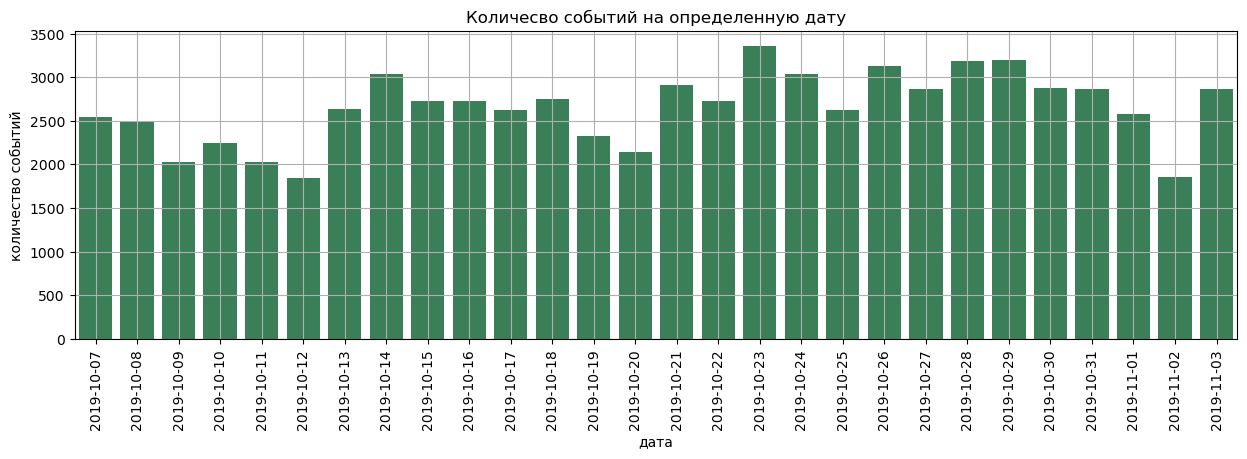

In [21]:
# построим гистограмму по количесву событий на определенную дату
df_pivot_table = df.pivot_table(index = 'date', values = 'event_name', aggfunc = 'count').reset_index()
df_pivot_table['date'] = df_pivot_table['date'].dt.date

plt.figure(figsize=(15, 4))
sns.barplot(x='date', y='event_name', data=df_pivot_table, color='seagreen')
plt.title('Количесво событий на определенную дату')
plt.xlabel('дата')
plt.ylabel('количество событий')
plt.xticks(rotation=90)
plt.grid();

Как видно из графика, клиенты используют приложение неравномерно, есть снижение активности, которое происходит по большей части в выходные дни.

Построим визуализацию динамики изменения поведения пользователей, совершающих целевое событие во времени.

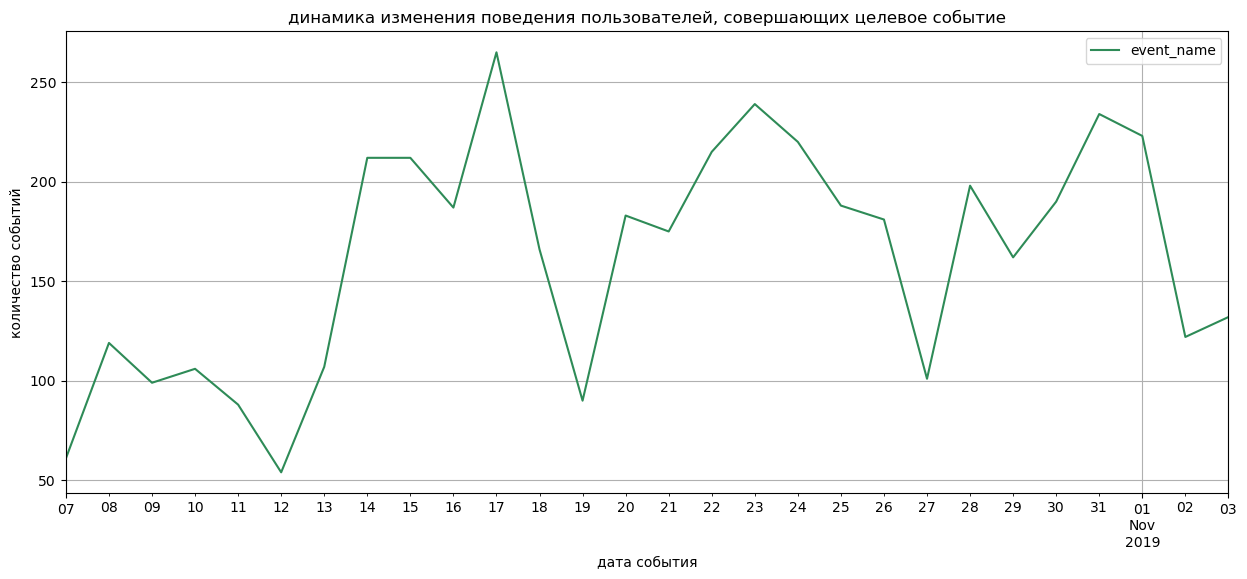

In [107]:
# построим визуализацию динамики изменения поведения пользователей, совершающих целевое событие во времени
df.query('event_name == "contacts_show"').pivot_table(index='date', values='event_name', aggfunc='count') \
    .plot(figsize=(15,6), title='динамика изменения поведения пользователей, совершающих целевое событие', grid=True, \
          color='seagreen')
plt.ylabel('количество событий')
plt.xlabel('дата события');

Как мы видим, просмотр контактов пользователями имеет цикличность. Проверим гипотезу, что спад активности приходится на выходные дни.

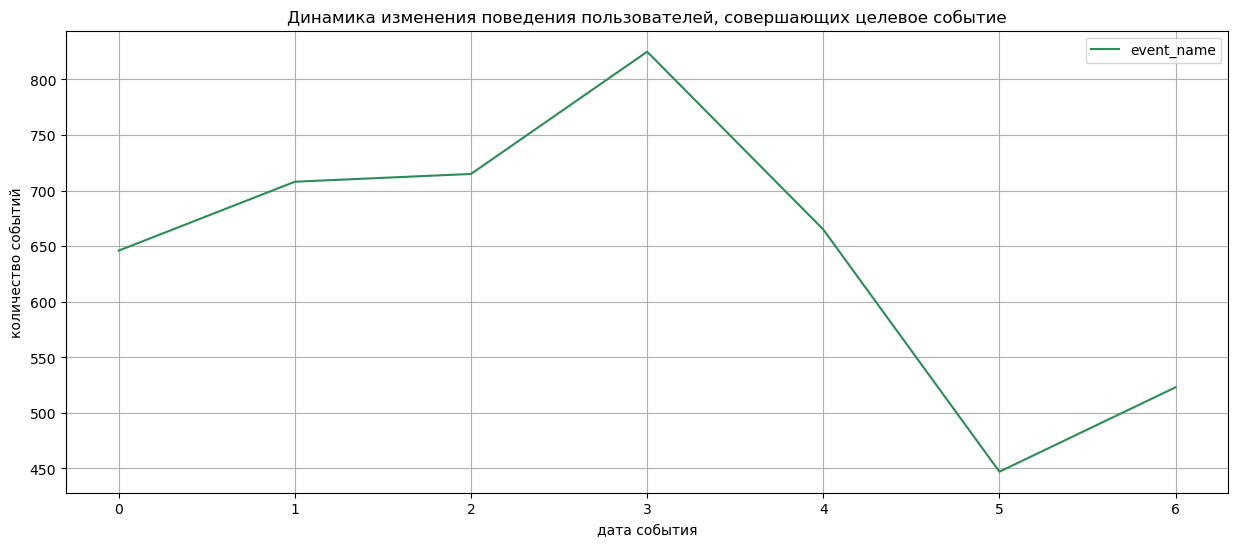

In [108]:
# создадим столбец с днем недели совершения действия
df['weekday_exposition'] = df['date'].dt.weekday

# построим визуализацию динамики изменения поведения пользователей, совершающих целевое в разбивке по дням недели
df.query('event_name == "contacts_show"').pivot_table(index='weekday_exposition', values='event_name', aggfunc='count') \
    .plot(figsize=(15,6), title='Динамика изменения поведения пользователей, совершающих целевое событие', grid=True, \
          color='seagreen')
plt.ylabel('количество событий')
plt.xlabel('дата события');

Пиковая активность наблюдается в четверг, резкий спад происходит к выходным.

Проведем оценку пользовательской активности. Рассчитаем показатель WAU - количество уникальных активных пользователей в неделю.

In [25]:
# найдем вермя старта каждой сессии
session_week = df.sort_values(by=['user_id', 'event_time']) \
        .groupby(['user_id', 'session_id']) \
        .agg({'event_time': 'min'}) \
        .rename(columns={'event_time': 'session_start'}) \
        .reset_index()

# создадим столбец с номером недели
session_week['week'] = session_week['session_start'].dt.isocalendar().week

# посчитаем WAU
session_week.groupby(['week']).agg({'user_id': 'nunique'}).mean()
print('WAU = ', int(session_week.groupby(['week']).agg({'user_id': 'nunique'}).mean())) 

WAU =  1381


Количество уникальных активных пользователей в неделю (WAU) = 1381 человек.

Выясним, из каких источников пользователи приходят в приложение и на какой источник приходится больше всего пользователей, совершающих целевое событие (просмотр контактов)

In [26]:
# построим таблицу, отражающую количество пользователей, совершающих целевое событие
user_source = df.query('event_name == "contacts_show"').groupby('source') \
    .agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False) \
    .rename(columns={'user_id': 'total_users'})
user_source['share_users'] = round(user_source['total_users'] / \
                                   df.query('event_name == "contacts_show"')['user_id'].nunique() * 100, 2)
user_source

,source,total_users,share_users
2,yandex,478,48.73
0,google,275,28.03
1,other,228,23.24


Видим, что из источника yandex приходит почти 50% пользователей, совершающих целевое событие. Из google 28%, из других источников 23%.

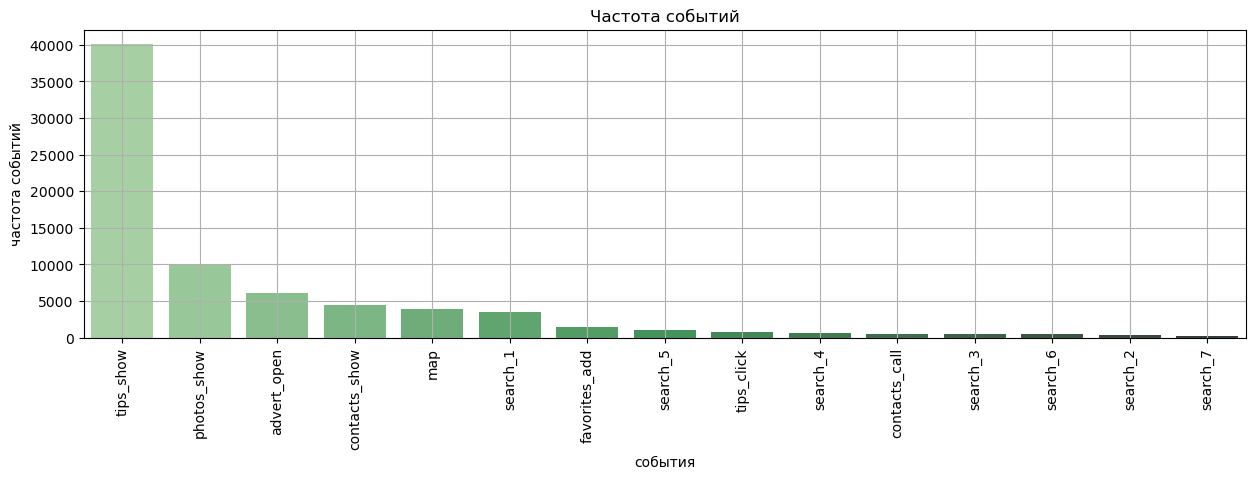

In [27]:
df_pivot_table2 = df.pivot_table(index = 'event_name', values = 'event_time', aggfunc = 'count').reset_index() \
    .rename(columns={'event_time': 'event_sum'}) \
    .sort_values(by='event_sum', ascending=False)

plt.figure(figsize=(15, 4))
sns.barplot(x='event_name', y='event_sum', data=df_pivot_table2, palette='Greens_d')
plt.title('Частота событий')
plt.xlabel('события')
plt.ylabel('частота событий')
plt.xticks(rotation=90)
plt.grid();

Самое частое событие среди всех пользователей - просмотр рекомендованных объявлений, второе событие по частоте - просмотр фотографий в объявлении, затем открытие карточки объявления, *просмотр контактов (целевое событие)* и открытие карты объявлений. Также мы видим, что разные действия, связанные с поиском по сайту (search_1—search_7) практически не отличаются по частоте использования. Объединим search_1—search_7 в одну категорию search. Вероятно, tips_show демонстрируется всем пользователям автоматически и не зависит от его действий.

In [28]:
# объединим search_1—search_7 в одну категорию search
df['event_name'] = df['event_name'].str.replace('search_+\d', 'search', regex=True)

df.event_name.unique()

array(['tips_show', 'map', 'search', 'photos_show', 'favorites_add',
       'contacts_show', 'contacts_call', 'advert_open', 'tips_click'],
      dtype=object)

**В ходе анализа поведения пользователей выяснено:**
- на пользователя приходится событий в среднем 17, по медиане 9;
- период данных, которыми мы располагаем: 27 days;
- конверсия показов рекомендованных объявлений в клики (CTR) составила 2%;
- просмотр контактов пользователями имеет пиковую активность в четверг, резкий спад происходит к выходным;
- количество уникальных активных пользователей в неделю (WAU) составляет 1381 человек;
- из источника yandex приходит почти 50% пользователей, совершающих целевое событие. Из google 28%, из других источников 23%;
- самое частое событие среди всех пользователей - просмотр рекомендованных объявлений, второе событие по частоте - просмотр фотографий в объявлении, затем открытие карточки объявления, просмотр контактов (целевое событие) и открытие карты объявлений.

### Воронка событий (влияние событий на конверсию в целевое действие )

In [29]:
# посчитаем сколько пользователей совершали каждое из событий

users_total = df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index() \
        .rename(columns={'user_id': 'total_users'})
users_total['share_users'] = round(users_total['total_users'] / df['user_id'].nunique() * 100, 2)
users_total

,event_name,total_users,share_users
0,tips_show,2801,65.25
1,search,1666,38.81
2,map,1456,33.92
3,photos_show,1095,25.51
4,contacts_show,981,22.85
5,advert_open,751,17.49
6,favorites_add,351,8.18
7,tips_click,322,7.50
8,contacts_call,213,4.96


In [110]:
# построим воронку событий
fig = px.funnel(users_total[:5], y='event_name', x='total_users')
fig.update_layout(title='Воронка событий')
fig.show()

Как можно заметить из таблицы, до события по просмотру контактов "contacts_show" доходит 23% пользователей. На конверсию в целевое действие влияют события в таком порядке:    
1. tips_show - увидеть рекомендованные объявления;
2. search - разные действия, связанные с поиском по сайту;
3. map - открыть карту объявлений;
4. photos_show - просмотреть фотографии в объявлении.

In [31]:
# посчитаем долю пользователей которая проходит на следующий шаг воронки
users_total['con'] =  (users_total.total_users / users_total.total_users.shift(1) * 100).round(2).abs()
users_total[:5]

,event_name,total_users,share_users,con
0,tips_show,2801,65.25,NaN
1,search,1666,38.81,59.48
2,map,1456,33.92,87.39
3,photos_show,1095,25.51,75.21
4,contacts_show,981,22.85,89.59


В ходе анализа событий, мы выясняли, что больше всего пользователей "теряется" на этапе поиска "search" 40% пользователей.
Всего 10% пользователей доходит от первого события до просмотра контактов.

Посчитаем частоту событий пользователей, которые совершили целевое действие (просмотр контактов).

In [32]:
# создадим список пользователей, совершивших целевое событие
users_list = df.query('event_name == "contacts_show"')['user_id'].unique()

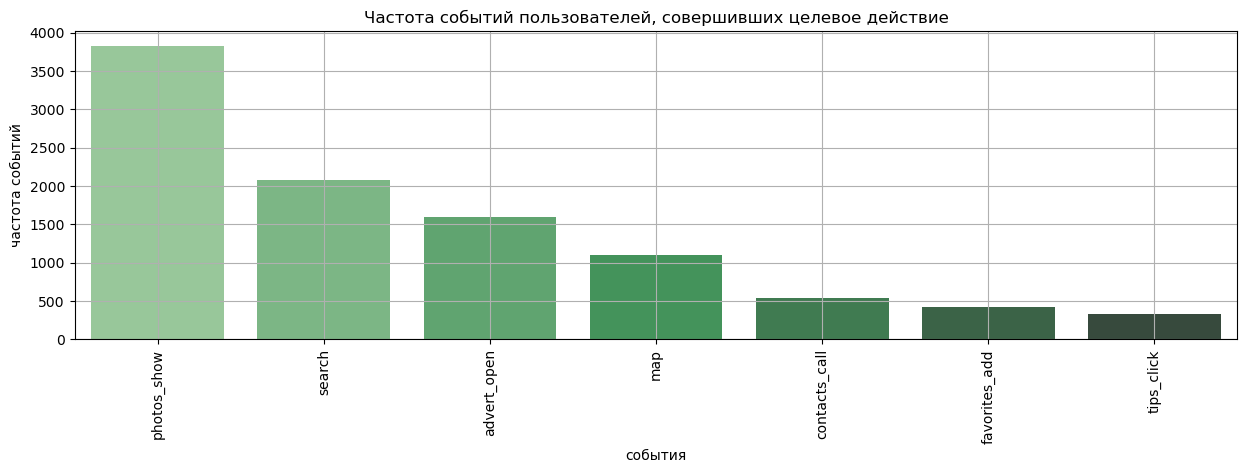

In [33]:
plt.figure(figsize=(15, 4))
sns.barplot(data=df.query('user_id in @users_list & event_name != "contacts_show" & event_name != "tips_show"') \
            .pivot_table(index = 'event_name', values = 'event_time', aggfunc = 'count').reset_index() \
            .rename(columns={'event_time': 'event_sum'}) \
            .sort_values(by='event_sum', ascending=False), \
            x='event_name', y='event_sum', palette='Greens_d')
plt.title('Частота событий пользователей, совершивших целевое действие')
plt.xlabel('события')
plt.ylabel('частота событий')
plt.xticks(rotation=90)
plt.grid();

Из исследования исключим атоматические события tips_show и целевое действие contacts_show. События располагаются в слудующем порядке:
- просмотр фотографий
- поиск
- открытие карточки
- просмотр карты
- звонок по номеру
- добавление карточки в избранное
- клик по рекомендованному объявлению.    

Действие - просмотр фотографий является абсолютным фаворитом среди пользователей, совершивших целевое действие.

**В ходе анализа воронки событий, выяснено:**    
- больше всего пользователей "теряется" на этапе поиска "search" 40%;
- пользователи, просмотревшие контакты, совершают еще действия: просмотр рекомендованных объявлений и просмотр карты;
- действие - просмотр фотографий является абсолютным фаворитом среди пользователей, совершивших целевое действие;
- до события по просмотру контактов "contacts_show" доходит 23% пользователей. На конверсию в целевое действие влияют события в таком порядке:
1. tips_show - увидеть рекомендованные объявления;
2. search - разные действия, связанные с поиском по сайту;
3. map - открыть карту объявлений;
4. photos_show - просмотреть фотографии в объявлении.

### Анализ сессий пользователей

Посмотрим на среднее число сессий на пользователя за день.

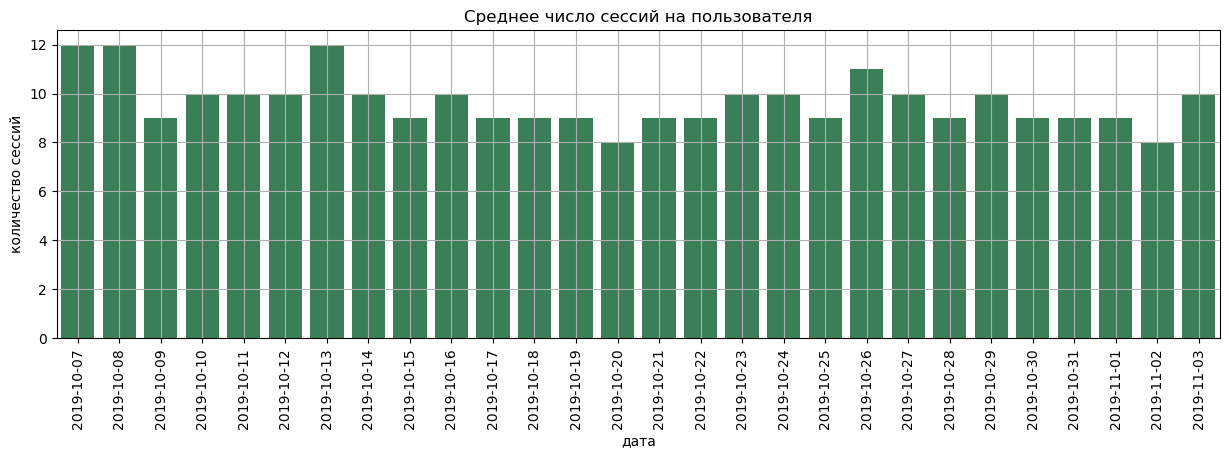

In [102]:
# посмотрим среднее число сессий на пользователя за день

# сначала посчитаем количество сессий на пользователя за день, затем среднее количество сессий за день
df_pivot_table3 = df.groupby(['date', 'user_id'])['session_id'].count().reset_index() \
            .groupby('date')['session_id'].mean().round().reset_index().rename(columns={'session_id': 'session_mean'})
df_pivot_table3['date'] = df_pivot_table3['date'].dt.date

plt.figure(figsize=(15, 4))
sns.barplot(data=df_pivot_table3, x='date', y='session_mean', color='seagreen')
plt.title('Среднее число сессий на пользователя')
plt.xlabel('дата')
plt.ylabel('количество сессий')
plt.xticks(rotation=90)
plt.grid();

Из видны пиковые значения среднего числа сессий на пользователя. Проверим, что рост активности приходится на выходные дни.

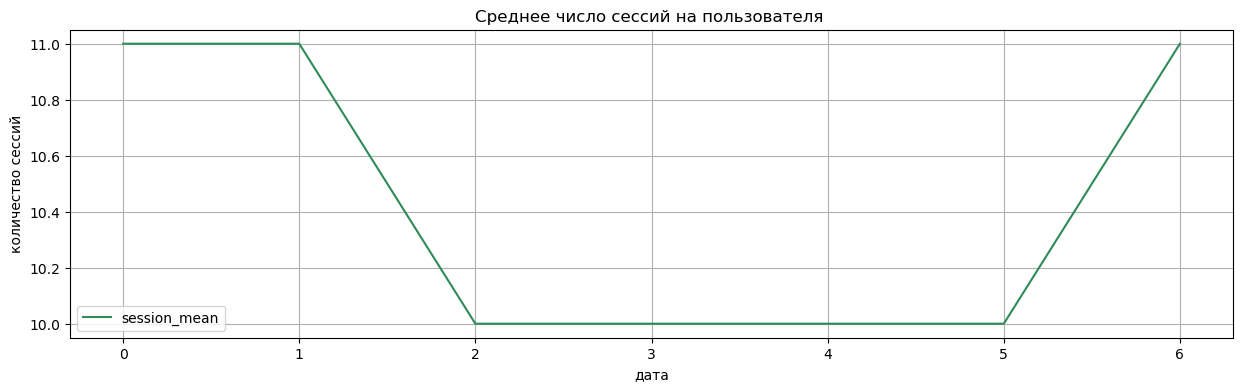

In [111]:
# посмотрим среднее число сессий на пользователя за день недели

# сначала посчитаем количество сессий на пользователя за день, затем среднее количество сессий за день
df.groupby(['weekday_exposition', 'user_id'])['session_id'].count().reset_index() \
    .groupby('weekday_exposition')['session_id'].mean().round().reset_index() \
    .rename(columns={'session_id': 'session_mean'}) \
    .plot(x='weekday_exposition', y='session_mean', \
          title='Среднее число сессий на пользователя ', figsize = (15,4), grid=True, xlabel='дата', \
                    ylabel='количество сессий', color='seagreen');

Из графиков мы можем наблюдать, что среднее число сессий на пользователя увеличивается к выходным в отличие от данных, что мы получили изучая количество событий в день, где количество событий в выходные резко падало, а пиковые значения были в середине недели. 

Посмотрим на среднее число сессий за день на пользователя, совершившего целевое действие.

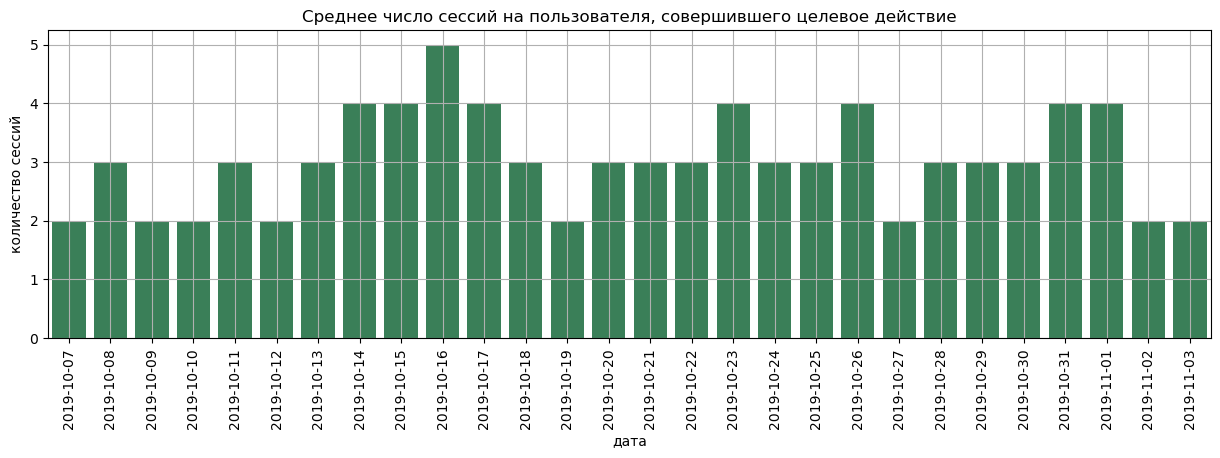

In [103]:
# посмотрим среднее число сессий на пользователя за день

# сначала посчитаем количество сессий на пользователя за день, затем среднее количество сессий за день
df_pivot_table4 = df.query('event_name == "contacts_show"').groupby(['date', 'user_id'])['session_id'].count().reset_index() \
    .groupby('date')['session_id'].mean().round().reset_index().rename(columns={'session_id': 'session_mean'})
df_pivot_table4['date'] = df_pivot_table4['date'].dt.date

plt.figure(figsize=(15, 4))
sns.barplot(data=df_pivot_table4, x='date', y='session_mean', color='seagreen')
plt.title('Среднее число сессий на пользователя, совершившего целевое действие')
plt.xlabel('дата')
plt.ylabel('количество сессий')
plt.xticks(rotation=90)
plt.grid();

Здесь мы видим проивоположную картину, когда пиковые значения среднего числа сессий на пользователя, совершившего целевое действие, приходится на будние дни. Проверим это графиком ниже.

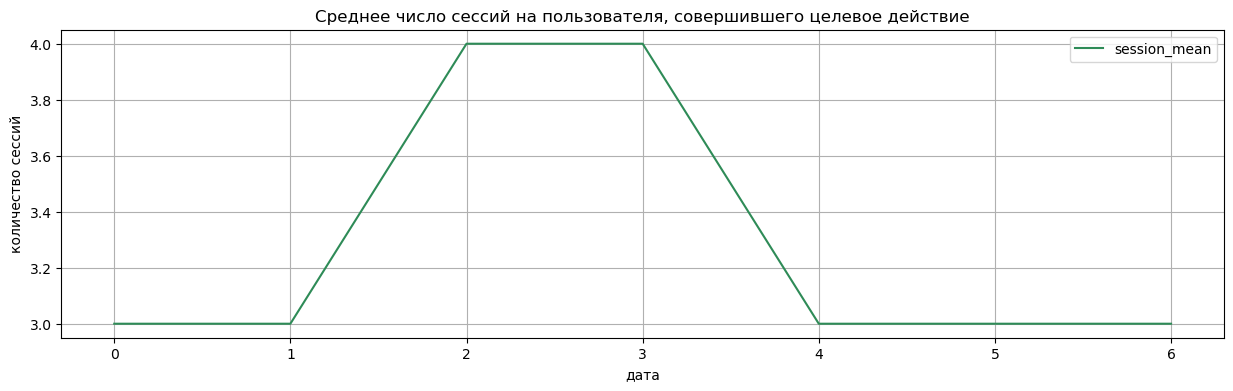

In [112]:
# посмотрим среднее число сессий на пользователя за день

# сначала посчитаем количество сессий на пользователя за день, затем среднее количество сессий за день
df.query('event_name == "contacts_show"').groupby(['weekday_exposition', 'user_id'])['session_id'].count().reset_index() \
    .groupby('weekday_exposition')['session_id'].mean().round().reset_index() \
    .rename(columns={'session_id': 'session_mean'}) \
    .plot(x='weekday_exposition', y='session_mean', \
          title='Среднее число сессий на пользователя, совершившего целевое действие', figsize = (15,4), grid=True, \
          xlabel='дата', ylabel='количество сессий', color='seagreen');

Действительно, пользователи, совершившие целевое действие более активны в будни, чем в выходные.

Посчитаем среднее время сессии пользователей в минутах.

In [40]:
# создадим таблицу 
session_avg = df.sort_values(by = ['user_id','event_time'])

# создадим столбец с разницей во времени между событиями пользователя
session_avg['delta'] = session_avg.groupby(['session_id'])['event_time'].apply(lambda x: x.diff()) 

# посчитаем время сессии пользователя
session_avg = session_avg.groupby(['user_id','session_id'])['delta'].sum().reset_index()

# найдем среднее время сессий пользователей
print('Среднее время сесии пользователей:', session_avg['delta'].mean())

Среднее время сесии пользователей: 0 days 00:12:52.672627050


Среднее время сессий пользователей составляет 13 минут.

#### Различие во времени между распространенными событиями пользователей.

In [41]:
# найдем распространенные события пользователей
top_event = df.groupby('event_name')['user_id'].nunique().reset_index().rename(columns={'user_id': 'user_sum'}) \
    .sort_values(by = ['user_sum'], ascending=False).head()
top_event_list = top_event['event_name'].tolist ()
top_event_list

['tips_show', 'search', 'map', 'photos_show', 'contacts_show']

In [113]:
# напишем функцию для построим графика различия между распространенными событиями пользователей
def event_plot(event_name1, event_name2):
    event_table = df.query('event_name == @event_name1 | event_name == @event_name2') \
        .sort_values(by = ['user_id','event_time']).drop_duplicates(subset=['session_id', 'event_name'])
    
    event_table['delta'] = event_table.groupby(['session_id'])['event_time'].apply(lambda x: x.diff())
    event_table['delta_min'] = event_table['delta'].astype('timedelta64[m]', errors = 'ignore') \
        .astype('int64', errors = 'ignore').fillna(0)
    
    event_table.pivot_table(index = 'date', values = 'delta_min', aggfunc = 'mean') \
    .plot(style='o-', title='Различие во времени между распространенными событиями пользователей', \
          figsize = (15,5), grid=True, xlabel='дата', ylabel='среднее время', color='seagreen') \
        .legend(bbox_to_anchor=(1, 1));
    print('Среднее время одной сессии в минутах' , round(event_table.query('delta_min < @minute')['delta_min'].mean(), 3))
    return 

Среднее время одной сессии в минутах 0.684


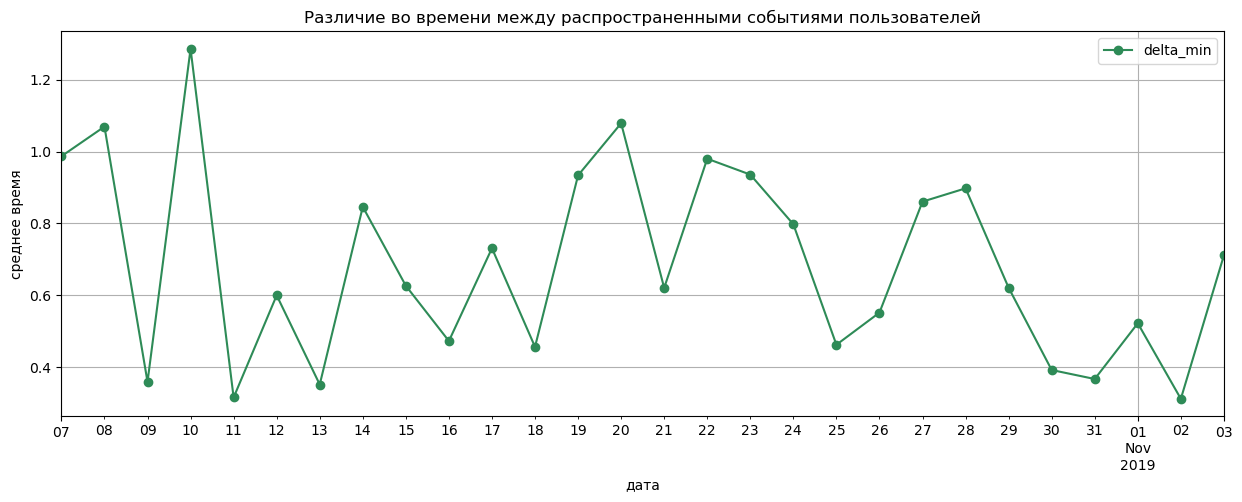

In [114]:
# построим график различия во времени между распространенными событиями contacts_show и photos_show пользователей

event_plot("contacts_show", "photos_show")

Среднее время между событиями просмотр контактов и просмотр фотографии объявления различается в разрезе дат. Мы можем наблюдать резкие пики в районе 1 минуты и спады меньше половины минуты.   
Среднее время одной сессии в минутах 0.684

Среднее время одной сессии в минутах 0.948


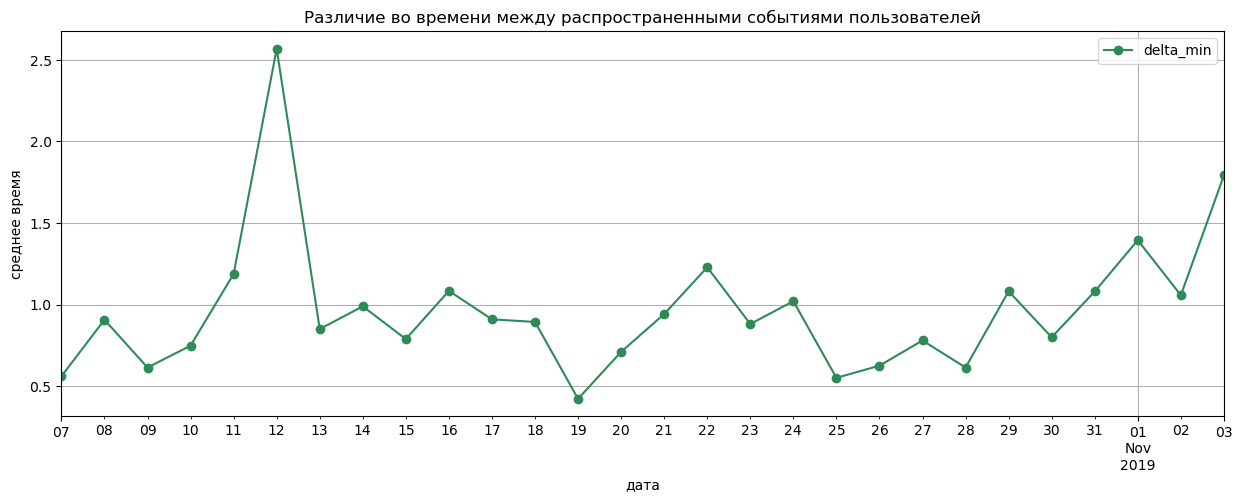

In [115]:
# построим график различия во времени между распространенными событиями contacts_show и tips_show пользователей

event_plot("contacts_show", "tips_show")

Среднее время между событиями просмотр контактов и просмотр рекомендованных объявлений относительно стабильно и колеблется в районе 1 минуты, есть резкий рост увеличения среднего времени между событиями 12 октября 2019 года в 2,5 минуты.   
Среднее время одной сессии в минутах 0.948

Среднее время одной сессии в минутах 0.802


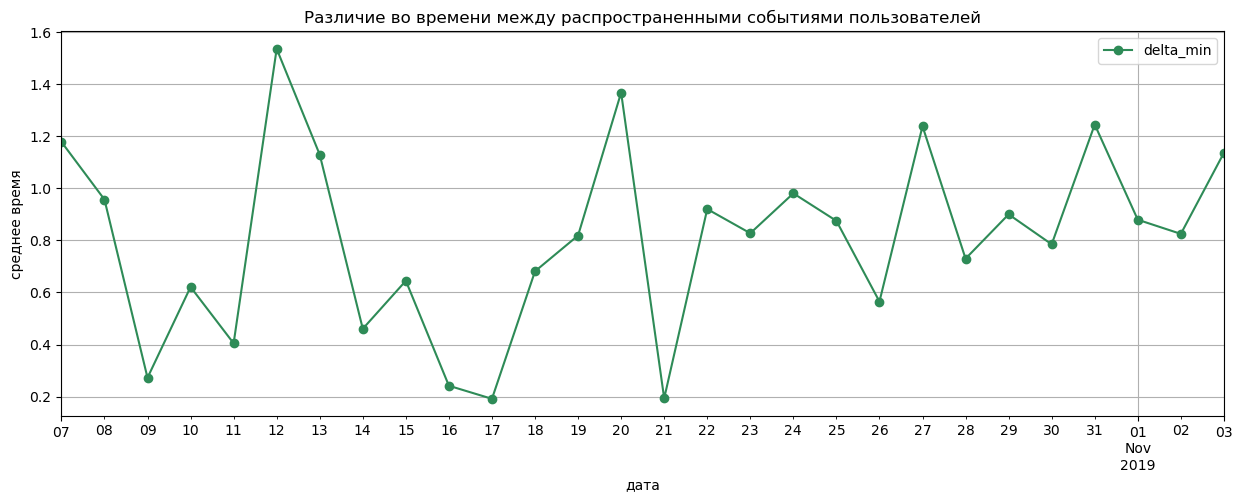

In [116]:
# построим график различия во времени между распространенными событиями contacts_show и search пользователей

event_plot("contacts_show", "search")

Среднее время между событиями просмотр контактов и поисковых запросов не стабильно.    
Оно колеблется от 1,5 минут и падает до уровня меньше половины минуты.    
Также можно увидеть резкий рост увеличения среднего времени между событиями 12 октября 2019 года.    
Среднее время одной сессии в минутах 0.802

Среднее время одной сессии в минутах 0.939


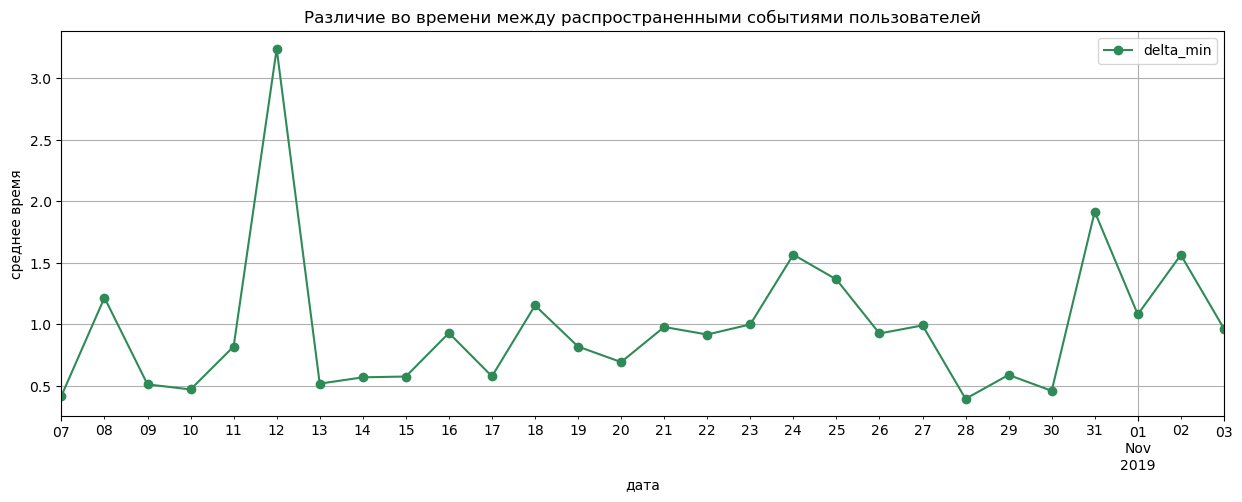

In [117]:
# построим график различия во времени между распространенными событиями contacts_show и search пользователей

event_plot("contacts_show", "map")

Среднее время между событиями просмотр контактов и просмотр карты объявлений относительно стабильно и колеблется в районе 1 минуты, есть резкий рост увеличения среднего времени между событиями 12 октября 2019 года больше чем в 3 минуты.    
Среднее время одной сессии в минутах 0.939

**В ходе анализа сессий пользователей выяснено:**
- среднее число сессий на пользователя увеличивается имеет пик на выходных;
- пользователи, совершившие целевое действие (просмотр контактов) более активны в будни, чем в выходные;
- среднее время сессий пользователей составляет 13 минут;
- есть резкий рост увеличения среднего времени между событиями 12 октября 2019 года (кроме событий просмотр контактов и просмотр фотографий). Следует обратить на это внимание, возможно, в приложении был сбой;
- меньше всего времени пользователи тратят в среднем в рамках сессии между событиями просмотр контактов и просмотр фотографии объявления, больше всего времени в среднем между событиями просмотр контактов и просмотр рекомендованных объявлений.

### Пользовательский путь (Диаграмма Санкея)

#### Диаграмма Санкея

Проанализируем пользовательский путь, посмотрим сценарии использования приложения.

In [47]:
# создадим копию таблицы и оставим только необходимые столбцы
table = df.loc[:, ['session_id', 'event_time', 'event_name']].copy()
display(table.head(15))

# удалим повторяющиеся события в рамках сессий
table = table.drop_duplicates(subset=['session_id', 'event_name'])
table.head(15)

,session_id,event_time,event_name
805,1,2019-10-07 13:39:45.989359,tips_show
806,1,2019-10-07 13:40:31.052909,tips_show
809,1,2019-10-07 13:41:05.722489,tips_show
820,1,2019-10-07 13:43:20.735461,tips_show
830,1,2019-10-07 13:45:30.917502,tips_show
831,1,2019-10-07 13:45:43.212340,tips_show
832,1,2019-10-07 13:46:31.033718,tips_show
836,1,2019-10-07 13:47:32.860234,tips_show
839,1,2019-10-07 13:49:41.716617,tips_show
6541,2,2019-10-09 18:33:55.577963,map


,session_id,event_time,event_name
805,1,2019-10-07 13:39:45.989359,tips_show
6541,2,2019-10-09 18:33:55.577963,map
6565,2,2019-10-09 18:40:28.738785,tips_show
36412,3,2019-10-21 19:52:30.778932,tips_show
36419,3,2019-10-21 19:53:38.767230,map
37556,4,2019-10-22 11:18:14.635436,map
37559,4,2019-10-22 11:19:10.529462,tips_show
31632,5,2019-10-19 21:34:33.849769,search
31655,5,2019-10-19 21:40:38.990477,photos_show
33482,6,2019-10-20 18:49:24.115634,search


Пропишем функции для диаграммы.

In [48]:
def add_features(df):
    
    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """
    
    # сортируем по id и времени
    sorted_df = df.sort_values(by=['session_id', 'event_time']).copy()
    # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event_name']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
    
    # возврат таблицы без имени событий
    return sorted_df.drop(['event_name'], axis=1)
  
# преобразуем таблицу
table = add_features(table)
table.head()

,session_id,event_time,step,source,target
805,1,2019-10-07 13:39:45.989359,1,tips_show,NaN
6541,2,2019-10-09 18:33:55.577963,1,map,tips_show
6565,2,2019-10-09 18:40:28.738785,2,tips_show,NaN
36412,3,2019-10-21 19:52:30.778932,1,tips_show,map
36419,3,2019-10-21 19:53:38.767230,2,map,NaN


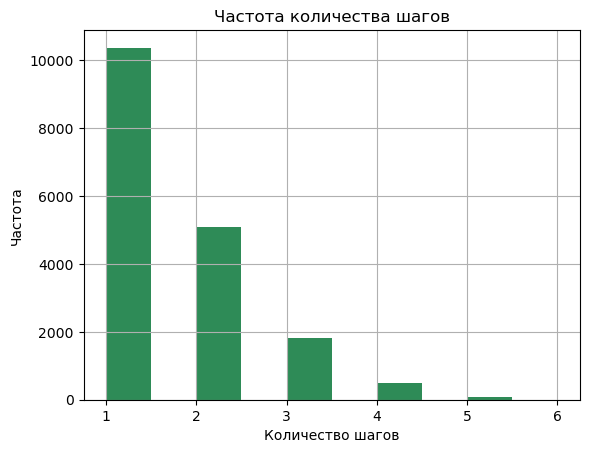

In [104]:
# посмотрим на распределение уникальных событий (переходов) в разрезе сессий 
table['step'].hist(color='seagreen')
plt.title('Частота количества шагов') 
plt.xlabel('Количество шагов')
plt.ylabel('Частота');
#, color='seagreen'

Оставим до 3х переходов в разрезе сессий, тк частота остальных шагов очень мала.

In [50]:
# удалим все пары source-target, шаг которых превышает 7
# и сохраним полученную таблицу в отдельную переменную
df_comp = table[table['step'] <= 3].copy().reset_index(drop=True)

In [51]:
def get_source_index(df):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(df_comp)

In [52]:
def generate_random_color():
    
    """Случайная генерация цветов rgba

    Args:
        
    Returns:
        str: Строка со сгенерированными параметрами цвета
    """
    
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [53]:
import requests
def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = requests.get('https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json').json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict
  
  
# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom')

In [54]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [55]:
from tqdm import tqdm
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

Шаг: 100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


In [56]:
from plotly import graph_objects as go
def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10, width=1000, height=600)
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()

In [57]:
senkey_diagram.show()

Действия пользователей:    

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

**Анализ диаграммы:**
1. Некоторые пользователи скорее всего переходят прямо по ссылке и событие просмотра контактов "contacts_show" является сразу первым сценарием. Больше всего пользователей перетекают в событие просмотра контактов "contacts_show" из события "tips_show".   
2. Выделим короткие сценарии, где просмотр контактов "contacts_show" является вторым шагом:
- tips_show - contacts_show
- photos_show - contacts_show
- search - contacts_show
- advert_open - contacts_show
- map - contacts_show 
    
3. Выделим сценарии, где просмотр контактов "contacts_show" является третьим шагом:
- search - photos_show - contacts_show
- search - map - contacts_show
- search - tips_show - contacts_show
- search - favorites_add - contacts_show
- search - advert_open - contacts_show
    
- favorites_add - photos_show - contacts_show
    
- photos_show - favorites_add - contacts_show
- photos_show - search - contacts_show
- photos_show - advert_open - contacts_show
    
- tips_show - favorites_add - contacts_show
- tips_show - map - contacts_show
- tips_show - search - contacts_show
- tips_show - tips_click - contacts_show
- tips_show - advert_open - contacts_show
    
- advert_open - photos_show - contacts_show
- advert_open - tips_show - contacts_show
- advert_open - search - contacts_show
    
- map - tips_show - contacts_show
- map - search - contacts_show
- map - advert_open - contacts_show
    
- tips_click - tips_show - contacts_show

Выделим несколько сценариев и построим по ним воронки событий:
- search - map - contacts_show
- search - tips_show - contacts_show
- map - advert_open - contacts_show
- search - photos_show - contacts_show

In [58]:
# создадим копию таблицы и оставим только необходимые столбцы
df_con = df.copy()
display(df_con.head())

# удалим повторяющиеся события в рамках сессий
df_con = df_con.drop_duplicates(subset=['session_id', 'event_name'])

# добавим шаги в таблицу
# сортируем по id и времени
df_con = df_con.sort_values(by=['session_id', 'event_time'])

# добавляем шаги событий
df_con['step'] = df_con.groupby('session_id').cumcount() + 1
    
df_con.head()

,event_time,event_name,user_id,date,source,session_id,weekday_exposition
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0


,event_time,event_name,user_id,date,source,session_id,weekday_exposition,step
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,other,2,2,1
6565,2019-10-09 18:40:28.738785,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,other,2,2,2
36412,2019-10-21 19:52:30.778932,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,other,3,0,1
36419,2019-10-21 19:53:38.767230,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,other,3,0,2


In [59]:
# создадим функцию для построения воронок по выбраным сценариям из 2х шагов
def f_con_2(x1, x2, y1, y2):
    list_event1 = []
    list_event2 = []
    list_event = []
    list_columns = ['event_name', 'total_users']
    
    list_event1.append(y1)
    list_event1.append(df_con.query('step == @x1 & event_name == @y1')['user_id'].nunique())
    
    list_event2.append(y2)
    list_event2.append(df_con.query('step == @x2 & event_name == @y2')['user_id'].nunique())
    
    list_event.append(list_event1)
    list_event.append(list_event2)
    
    v = pd.DataFrame(data=list_event , columns=list_columns)
    v['share_users'] = round(v['total_users'] / v['total_users'].sum() * 100, 2)
    v['con'] =  (v.total_users / v.total_users.shift(1) * 100).round(2).abs()
    
    fig = px.funnel(v, y='event_name', x='total_users')
    fig.update_layout(title='Воронка событий')

    return display(v), fig.show()

In [60]:
# создадим функцию для построения воронок по выбраным сценариям из 3х шагов
def f_con(x1, x2, x3, y1, y2, y3):
    list_event1 = []
    list_event2 = []
    list_event3 = []
    list_event = []
    list_columns = ['event_name', 'total_users']
    
    list_event1.append(y1)
    list_event1.append(df_con.query('step == @x1 & event_name == @y1')['user_id'].nunique())
    
    list_event2.append(y2)
    list_event2.append(df_con.query('step == @x2 & event_name == @y2')['user_id'].nunique())
    
    list_event3.append(y3)
    list_event3.append(df_con.query('step == @x3 & event_name == @y3')['user_id'].nunique())
    
    list_event.append(list_event1)
    list_event.append(list_event2)
    list_event.append(list_event3)
    
    v = pd.DataFrame(data=list_event , columns=list_columns)
    v['share_users'] = round(v['total_users'] / v['total_users'].sum() * 100, 2)
    v['con'] =  (v.total_users / v.total_users.shift(1) * 100).round(2).abs()
    
    fig = px.funnel(v, y='event_name', x='total_users')
    fig.update_layout(title='Воронка событий')

    return display(v), fig.show()

#### Сценарий "поиск  - просмотр контактов"

In [61]:
# построим воронку по сценарию search - contacts_show

f_con_2(1, 2, "search", "contacts_show")

,event_name,total_users,share_users,con
0,search,1402,73.21,NaN
1,contacts_show,513,26.79,36.59


(None, None)

Как можно заметить из таблицы, после поиска до события по просмотру контактов "contacts_show" доходит 27% пользователей.    
На этапе просмотра контактов "теряется" 63% пользователей.

#### Сценарий "карта - просмотр контактов"

In [62]:
# построим воронку по сценарию map - contacts_show

f_con_2(1, 2, "map", "contacts_show")

,event_name,total_users,share_users,con
0,map,966,65.31,NaN
1,contacts_show,513,34.69,53.11


(None, None)

Как можно заметить из таблицы, после просмотра карты до события по просмотру контактов "contacts_show" доходит 34% пользователей.    
На этапе просмотра контактов "теряется" 47% пользователей.

#### Сценарий "просмотр фотографий - просмотр контактов"

In [63]:
# построим воронку по сценарию photos_show - contacts_show

f_con_2(1, 2, "photos_show", "contacts_show")

,event_name,total_users,share_users,con
0,photos_show,721,58.43,NaN
1,contacts_show,513,41.57,71.15


(None, None)

Как можно заметить из таблицы, после просмотра фотографий до события по просмотру контактов "contacts_show" доходит 42% пользователей.    
На этапе просмотра контактов "теряется" 29% пользователей.

#### Сценарий "поиск - карта объявлений - просмотр контактов"

In [64]:
# построим воронку по сценарию search - map - contacts_show

f_con(1, 2, 3, "search", "map", "contacts_show")

,event_name,total_users,share_users,con
0,search,1402,64.64,NaN
1,map,509,23.47,36.31
2,contacts_show,258,11.89,50.69


(None, None)

Как можно заметить из таблицы, до события по просмотру контактов "contacts_show" доходит 12% пользователей.    
Больше всего пользователей "теряется" на этапе просмотра карты "map" 64% пользователей. 

#### Сценарий "поиск - рекомендованные объявления - просмотр контактов"

In [65]:
# построим воронку по сценарию search - tips_show - contacts_show

f_con(1, 2, 3, "search", "tips_show", "contacts_show")

,event_name,total_users,share_users,con
0,search,1402,49.23,NaN
1,tips_show,1188,41.71,84.74
2,contacts_show,258,9.06,21.72


(None, None)

Как можно заметить из таблицы, до события по просмотру контактов "contacts_show" доходит 9% пользователей.    
Больше всего пользователей "теряется" на этапе просмотра контактов "contacts_show" 78% пользователей. 

#### Сценарий "карта - рекомендованные объявления - просмотр контактов"

In [66]:
# построим воронку по сценарию map - advert_open - contacts_show

f_con(1, 2, 3, "map", "advert_open", "contacts_show")

,event_name,total_users,share_users,con
0,map,966,62.77,NaN
1,advert_open,315,20.47,32.61
2,contacts_show,258,16.76,81.90


(None, None)

Как можно заметить из таблицы, до события по просмотру контактов "contacts_show" доходит 17% пользователей.    
Больше всего пользователей "теряется" на этапе открытие карточки объявления "advert_open" 67% пользователей. 

#### Сценарий "поиск - просмотр фотографий - просмотр контактов"

In [67]:
# построим воронку по сценарию search - photos_show - contacts_show

f_con(1, 2, 3, "search", "photos_show", "contacts_show")

,event_name,total_users,share_users,con
0,search,1402,64.67,NaN
1,photos_show,508,23.43,36.23
2,contacts_show,258,11.90,50.79


(None, None)

Как можно заметить из таблицы, до события по просмотру контактов "contacts_show" доходит 12% пользователей.    
Больше всего пользователей "теряется" на этапе просмотр фотографии объявления "photos_show" 64% пользователей. 

**Вывод по анализу воронок событий из 2 шагов:**    
1. Сценарий "поиск - просмотр контактов":
- до события по просмотру контактов "contacts_show" доходит 27% пользователей, на этапе просмотра контактов "теряется" 63% пользователей.
2. Сценарий "карта - просмотр контактов":
- до события по просмотру контактов "contacts_show" доходит 34% пользователей, на этапе просмотра контактов "теряется" 47% пользователей.
3. Сценарий "просмотр фотографий - просмотр контактов":
-  до события по просмотру контактов "contacts_show" доходит 42% пользователей, на этапе просмотра контактов "теряется" 29% пользователей.
    
**Вывод по анализу воронок событий из 3 шагов:**
1. Сценарий "поиск - карта объявлений - просмотр контактов":
-  до события по просмотру контактов "contacts_show" доходит 12% пользователей, больше всего пользователей "теряется" на этапе просмотра карты "map" 64% пользователей.
2. Сценарий "поиск - рекомендованные объявления - просмотр контактов":
- до события по просмотру контактов "contacts_show" доходит 9% пользователей, больше всего пользователей "теряется" на этапе просмотра контактов "contacts_show" 78% пользователей.
3. Сценарий "карта - рекомендованные объявления - просмотр контактов":
-  до события по просмотру контактов "contacts_show" доходит 17% пользователей, больше всего пользователей "теряется" на этапе открытие карточки объявления "advert_open" 67% пользователей.
4. Сценарий "поиск - просмотр фотографий - просмотр контактов":
- до события по просмотру контактов "contacts_show" доходит 12% пользователей, больше всего пользователей "теряется" на этапе просмотр фотографии объявления "photos_show" 64% пользователей.

**Вывод:**    
    
Сценарий "просмотр фотографий - просмотр контактов" самый перспективный из сценариев в 2 шага. До события по просмотру контактов "contacts_show" доходит 42% пользователей, "теряется" всего 29% пользователей. 
    
Сценарий "карта - рекомендованные объявления - просмотр контактов" самый перспективный из сценариев в 3 шага. До события по просмотру контактов "contacts_show" доходит 17% пользователей, больше всего пользователей "теряется" на этапе открытие карточки объявления "advert_open" 67% пользователей. Следует обратить на это внимание.

### Конверсия событий в целевое действие

In [68]:
# добавим столбец с предыдущим событием в таблицу
df['next_event'] = df.sort_values(by=['session_id', 'event_time'])['event_name'].shift(-1)
df.head(10)

,event_time,event_name,user_id,date,source,session_id,weekday_exposition,next_event
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,tips_show
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,tips_show
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,tips_show
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,tips_show
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,tips_show
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,tips_show
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,tips_show
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,tips_show
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,1,0,map
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,other,2,2,map


Отфильтруем датафрейм, где next_event = contacts_show, найдем события, предшествующие событию contacts_show и определим для каждого события, сколько раз оно предшествовало целевому событию.

In [69]:
# события, предшествующие целевому действию
df_befor_contacts_show = df.query('next_event=="contacts_show"').groupby('event_name').\
    agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False).reset_index().\
    rename(columns={'event_name':'event', 'user_id':'count'})
df_befor_contacts_show

,event,count
0,tips_show,567
1,contacts_show,351
2,photos_show,280
3,search,166
4,contacts_call,101
5,advert_open,50
6,map,46
7,favorites_add,42
8,tips_click,9


In [70]:
# вычислим конверсию событий в целевое действие
df_contacts_show = df.groupby('event_name').\
    agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False).reset_index().\
    rename(columns={'event_name':'event', 'user_id':'general_count'})
df_contacts_show

,event,general_count
0,tips_show,2801
1,search,1666
2,map,1456
3,photos_show,1095
4,contacts_show,981
5,advert_open,751
6,favorites_add,351
7,tips_click,322
8,contacts_call,213


In [71]:
# соединим 2 таблицы 
df_join = df_befor_contacts_show.merge(df_contacts_show[['event','general_count']], on='event', how='left')

df_join['con'] = round(df_join['count']/df_join['general_count'] * 100, 2)
df_join = df_join.sort_values(by='con', ascending=False)
df_join

,event,count,general_count,con
4,contacts_call,101,213,47.42
1,contacts_show,351,981,35.78
2,photos_show,280,1095,25.57
0,tips_show,567,2801,20.24
7,favorites_add,42,351,11.97
3,search,166,1666,9.96
5,advert_open,50,751,6.66
6,map,46,1456,3.16
8,tips_click,9,322,2.80


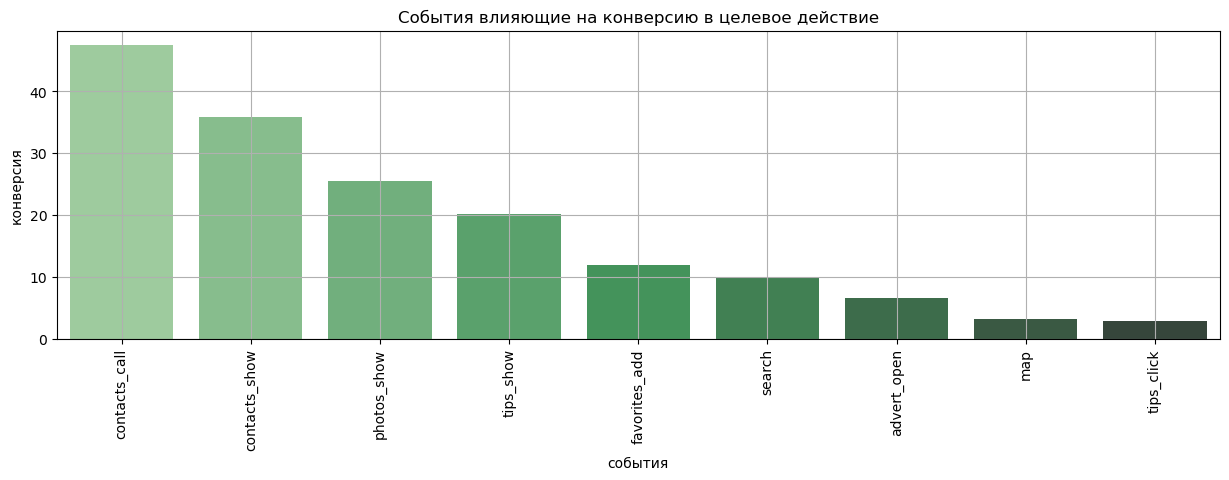

In [101]:
plt.figure(figsize=(15, 4))
sns.barplot(data=df_join, x='event', y='con', palette='Greens_d')
plt.title('События влияющие на конверсию в целевое действие')
plt.xlabel('события')
plt.ylabel('конверсия')
plt.xticks(rotation=90)
plt.grid();

**Вывод:**
    
1. Самая высокая конверсия у события звонок по номеру "contacts_call", что логично, но количество таких событий очень мало, но данный факт не влияет на исследование.
    
2. Конверсия события просмотр контактов "contacts_show" может говорить о повторных действиях пользователей или технической проблеме. 

3. Высокая коверсия у события просмотр фото "photo_show" 26%, что подтверждает теорию о стимулировании пользователей выкладывать больше фото.

3. 12% конверсия события добавления объявления в избранные "favorites_add".

4. У событий поиск, открытие карточки, просмотр карты и кликов по объявлению конверсия меньше 10%.

## Проверка гипотез

### Проверка гипотезы:     
Конверсия в просмотры контактов различается у группы пользователей, совершающих действия увидел рекомендованные объявления `tips_show`, кликнул по рекомендованному объявлению`tips_click` и группы пользователей, совершающих действие увидел рекомендованные объявления `tips_show`.

H_0: Конверсия в просмотры контактов группы пользователей, совершающих действия 'tips_show' и 'tips_click' = конверсия в просмотры контактов группы пользователей, совершающих действия 'tips_show'   

H_a: Конверсия в просмотры контактов группы пользователей, совершающих действия 'tips_show' и 'tips_click' ≠ конверсия в просмотры контактов группы пользователей, совершающих действия 'tips_show'

критический уровень статистической значимости alpha = 0.05

In [73]:
# выделим уникальных пользователей, которые совершили действие tips_show, в список tips_show_user_list.
tips_show_user_list = df.query('event_name == "tips_show"')['user_id'].unique()

In [74]:
# выделим уникальных пользователей, которые совершили действие tips_show и tips_click, в список tips_click_user_list
tips_click_user_list = df.query('event_name == "tips_click" and user_id in @tips_show_user_list')['user_id'].unique()

Проверим на пересечение общих элементов в двух наборах методом numpy.intersect1d(). Метод numpy.intersect1d() берет массивы и возвращает отсортированное пересечение в виде другого одномерного массива.

In [75]:
A = np.array(tips_show_user_list)
B = np.array(tips_click_user_list)
C = np.intersect1d(A, B)
print(len(C), 'общих пользователей в группе А и В')
print(len(A), 'пользователей в группе А')
print(len(B), 'пользователей в группе В')

297 общих пользователей в группе А и В
2801 пользователей в группе А
297 пользователей в группе В


In [76]:
# Исключим пользователей группы В из группы А
# cформируем два датафрейма на базе исходного, фильтруя по спискам tips_show_user_list и tips_click_user_list
data_tips_show = df.query('user_id in @tips_show_user_list')
data_tips_show = data_tips_show.query('user_id not in @C')
data_tips_click = df.query('user_id in @tips_click_user_list')
data_tips_show['user_id'].nunique()

2504

In [77]:
# найдем количество пользователей из датасетов data_tips_show и data_tips_click, которые совершили действие contacts_show
print(data_tips_show.query('event_name == "contacts_show"')['user_id'].nunique(), 'пользователей группы А посмотрели контакты')
print(data_tips_click.query('event_name == "contacts_show"')['user_id'].nunique(), 'пользователей группы В посмотрели контакты')

425 пользователей группы А посмотрели контакты
91 пользователей группы В посмотрели контакты


In [78]:
print(round(data_tips_show.query('event_name == "contacts_show"')['user_id'].nunique() / \
            len(A) * 100), '% пользователей группы А посмотрели контакты')

print(round(data_tips_click.query('event_name == "contacts_show"')['user_id'].nunique() / \
            len(B) * 100), '% пользователей группы B посмотрели контакты')

15 % пользователей группы А посмотрели контакты
31 % пользователей группы B посмотрели контакты


In [79]:
# функция для проверки статистических гипотез
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    print('p-значение: ', p_value)
 
    if (p_value < alpha): 
        display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

In [80]:
z_test(data_tips_show.query('event_name == "contacts_show"')['user_id'].nunique(), \
       data_tips_click.query('event_name == "contacts_show"')['user_id'].nunique(), data_tips_show['user_id'].nunique(), \
       data_tips_click['user_id'].nunique(), alpha=0.05)

p-значение:  9.218316554537864e-09


'Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия'

Такая разница в пропорциях при указанных размерах выборок достаточна, чтобы говорить о статистически значимом различии. Поэтому отвергаем нулевую гипотезу и не отвергаем альтернативную: различия в конверсии между группами есть.

### Проверка гипотезы:     

Конверсия в просмотры различается у группы пользователей, открывающих карточку объявления `advert_open` и группы пользователей, просматривающих фотографии карточки `photos_show`.

H_0: Конверсия в просмотры контактов группы пользователей, открывающих карточку объявления 'advert_open' = конверсия в просмотры контактов группы пользователей, просматривающих фотографии карточки 'photos_show'   

H_a: Конверсия в просмотры контактов группы пользователей, открывающих карточку объявления 'advert_open' ≠ конверсия в просмотры контактов группы пользователей, просматривающих фотографии карточки 'photos_show'   

критический уровень статистической значимости alpha = 0.05

In [81]:
# выделим уникальных пользователей, которые совершили действие advert_open, в список advert_open_user_list.
advert_open_user_list = df.query('event_name == "advert_open"')['user_id'].unique()

In [82]:
# выделим уникальных пользователей, которые совершили действие photos_show, в список photos_show_user_list
photos_show_user_list = df.query('event_name == "photos_show"')['user_id'].unique()

Проверим на пересечение общих элементов в двух наборах методом numpy.intersect1d(). Метод numpy.intersect1d() берет массивы и возвращает отсортированное пересечение в виде другого одномерного массива.

In [83]:
AA = np.array(advert_open_user_list)
BB = np.array(photos_show_user_list)
CC = np.intersect1d(AA, BB)
print(len(CC), 'общих пользователей в группе А и В')
print(len(AA), 'пользователей в группе А')
print(len(BB), 'пользователей в группе В')

73 общих пользователей в группе А и В
751 пользователей в группе А
1095 пользователей в группе В


In [84]:
# Исключим пользователей группы A из группы B
# cформируем два датафрейма на базе исходного, фильтруя по спискам advert_open_user_list и photos_show_user_list
data_advert_open = df.query('user_id in @advert_open_user_list')
data_advert_open = data_advert_open.query('user_id not in @CC')
data_photos_show = df.query('user_id in @photos_show_user_list')
data_photos_show['user_id'].nunique()

1095

In [85]:
# найдем количество пользователей из датасетов data_tips_show и data_tips_click, которые совершили действие contacts_show
print(data_advert_open.query('event_name == "contacts_show"')['user_id'].nunique(), 'пользователей группы А посмотрели контакты')
print(data_photos_show.query('event_name == "contacts_show"')['user_id'].nunique(), 'пользователей группы В посмотрели контакты')

100 пользователей группы А посмотрели контакты
339 пользователей группы В посмотрели контакты


In [86]:
print(round(data_advert_open.query('event_name == "contacts_show"')['user_id'].nunique() / \
            len(AA) * 100), '% пользователей группы А посмотрели контакты')

print(round(data_photos_show.query('event_name == "contacts_show"')['user_id'].nunique() / \
            len(BB) * 100), '% пользователей группы B посмотрели контакты')

13 % пользователей группы А посмотрели контакты
31 % пользователей группы B посмотрели контакты


In [87]:
z_test(data_advert_open.query('event_name == "contacts_show"')['user_id'].nunique(), \
       data_photos_show.query('event_name == "contacts_show"')['user_id'].nunique(), data_advert_open['user_id'].nunique(), \
       data_photos_show['user_id'].nunique(), alpha=0.05)

p-значение:  1.532107773982716e-14


'Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия'

Такая разница в пропорциях при указанных размерах выборок достаточна, чтобы говорить о статистически значимом различии. Поэтому отвергаем нулевую гипотезу и не отвергаем альтернативную: различия в конверсии между группами есть.

## Выводы и рекомендации

**Вывод:**    
    
В ходе анализа поведения пользователей выяснено:    
    
- на пользователя приходится событий в среднем 17, по медиане 9;
- конверсия показов рекомендованных объявлений в клики (CTR) составила 2%;
- количество уникальных активных пользователей в неделю (WAU) составляет 1381 человек;
- из источника yandex приходит почти 50% пользователей, совершающих целевое событие. Из google 28%, из других источников 23%;
- самое частое событие среди всех пользователей - просмотр рекомендованных объявлений, второе событие по частоте - просмотр фотографий в объявлении, затем открытие карточки объявления, просмотр контактов (целевое событие) и открытие карты объявлений.
    
В ходе анализа воронки событий, выяснено:    
    
- больше всего пользователей "теряется" на этапе поиска "search" 40%;
- действие - просмотр фотографий является абсолютным фаворитом среди пользователей, совершивших целевое действие;
- до события по просмотру контактов "contacts_show" доходит 23% пользователей. На конверсию в целевое действие влияют события в таком порядке:
1. tips_show - увидеть рекомендованные объявления;
2. search - разные действия, связанные с поиском по сайту;
3. map - открыть карту объявлений;
4. photos_show - просмотреть фотографии в объявлении.
    
В ходе анализа сессий пользователей выяснено:

- среднее число сессий на пользователя увеличивается имеет пик на выходных;
- пользователи, совершившие целевое действие (просмотр контактов) более активны в будни, чем в выходные;
- среднее время сессий пользователей составляет 13 минут;
- есть резкий рост увеличения среднего времени между событиями 12 октября 2019 года (кроме событий просмотр контактов и просмотр фотографий). Следует обратить на это внимание, возможно, в приложении был сбой.
    
В ходе анализа сценариев использования приложения выяснено:    
    
Некоторые пользователи скорее всего переходят прямо по ссылке и событие просмотра контактов "contacts_show" является сразу первым сценарием. Больше всего пользователей перетекают в событие просмотра контактов "contacts_show" из события "tips_show".    
Анализируя возможные пути пользователя при использовании приложения, можно выделить входные точки воронок: просмотр рекомендованных объявлений, просмотр фотографий в объявлении, поисковые запросы, открытие карточки объявлений и открытие карты объявлений:    
- tips_show - contacts_show
- photos_show - contacts_show
- search - contacts_show
- advert_open - contacts_show
- map - contacts_show
    
Сценарий "просмотр фотографий - просмотр контактов" самый перспективный из сценариев в 2 шага. До события по просмотру контактов "contacts_show" доходит 42% пользователей, "теряется" всего 29% пользователей.    
Сценарий "карта - рекомендованные объявления - просмотр контактов" самый перспективный из сценариев в 3 шага. До события по просмотру контактов "contacts_show" доходит 17% пользователей, больше всего пользователей "теряется" на этапе открытие карточки объявления "advert_open" 67% пользователей. Следует обратить на это внимание.

Высокая коверсия у события просмотр фото "photo_show" 26%, что подтверждает теорию о стимулировании пользователей выкладывать больше фотографий.

Пользователи больше пользуются поисковой строкой, однако функционал карты также имеют определенную популярность. 
    
Проверены гипотезы:    
    
1.Конверсия в просмотры контактов различается у группы пользователей, совершающих действия увидел рекомендованные объявления tips_show, кликнул по рекомендованному объявлению tips_click и группы пользователей, совершающих действие увидел рекомендованные объявления tips_show.    
    
Различия в конверсии между группами есть. 31% пользователей, которые увидели и кликнули по рекомендованному объявлению, конвертировались в просмотр контактов и 15 % пользователей, которые увидели и не кликнули рекомендованные объявления.

2.Конверсия в просмотры различается у группы пользователей, открывающих карточку объявления advert_open и группы пользователей, просматривающих фотографии карточки photos_show.    
    
Различия в конверсии между группами есть. 31% пользователей, которые просмотрели фотографию объявления, конвертировались в просмотр контактов и 13 % пользователей, которые открывают карточку объявления.

**Рекомендации:**
    
- стоит обратить внимание на потерю 67% пользователей на этапе открытие карточки объявления "advert_open" в перспективном сценарии использования приложения из 3х шагов "карта - рекомендованные объявления - просмотр контактов";
- стоит обратить внимание на просмотр фотографий пользователями и простимульровать клиентов добавлять фото для повышения коверсии в просмотр контактов;
- стоит обратить внимание на пользователей увидели и кликнули по рекомендованному объявлению, для повышения коверсии в просмотр контактов;
- стоит улучшать качество функционала популярных сценариев использования приложения из 2 шагов и стимулировать клиента пользоваться картой, так как наблюдается высокая конверсия данного действия в целевое действие.
- для увеличения конверсии в целевое событие можно добавить, например, персонализированные UX-стратегии, e-mail рассылки, персональные рекомендации, push-уведомления. Можно ввести определённые "награды" или привилегии для постоянных пользователей. Также, можно ввести поощрение пользователей за добавление фото в объявление.